# Click Click Photography Image Classification

Whats left to do:
* Write-up
* Presentation
* Document/comment code
* Depending on prediction-score classify the image into a folder automatically
* Interaction for user for deciding which group the image should go in
* Other/better model than resnet50!!
* Doing oversampling in prepare_data class - But doesn't seem to work too well... Better suggestions?
* A lot of parameters are still hardcoded in the classes. Maybe move them to the calls in this notebook?
* ...

## Setup

### Libraries

In [1]:
# DS Tools
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
from collections import Counter
from timeit import default_timer as timer
import tqdm


# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.rcParams['font.size'] = 14

# Image manipulations
from PIL import Image

# Splitting
from sklearn.model_selection import train_test_split

# Neural Networks
import torch
from torch import Tensor, nn, optim, cuda
import torch.nn as nn
from torch.nn.functional import interpolate
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
#from torchsummary import summary
from torch.utils.data import DataLoader, sampler

# Error handling
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### User defined functions and classes

In [2]:
from src.prepare_data import prepare_data
from src.nn_class import nn_class

### Constants

In [3]:
# Where the input images are located
PATH = f"images_final/"
PATH = f"relabeled_data/"

# Directories for model
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"

### Prepare data for the model
This step takes the given input data, splits between train/test/validation. For the training step, it also oversamples, in order to combat class imbalanced.
Doesn't return anything, but sets up the images in the correct folder, oversampled

In [4]:
prepare_data(PATH, traindir, validdir, testdir, do_oversampling = False, oversampling = 1)

## Neural network model
Load model (and/or train)
Might need to disable load_checkpoint() two cells down if running for the first time

In [5]:
nnc = nn_class(batch_size = 128, traindir=traindir, validdir=validdir, testdir=testdir)

Train on gpu: True
1 gpus detected.
True False
There are 5 different classes.


### Choose a model 
Currently only resnet work, but I suspect it is trivial to get the remaining two up and running. I __THINK__ only `set_model` needs to be fixed.

Choose one, and let the remaining be commented out.

_(Also comment out `load_checkpoint` if this is your first time running for that model)_

In [6]:
#nnc.set_model('resnet50', describe_model=False) # Set to true to see which model we built
nnc.set_model('resnet18', describe_model=False) # Set to true to see which model we built
#nnc.set_model('wide_resnet50_2', describe_model=False) # Set to true to see which model we built

# These ones don't work (yet?) - But suspect they are promising, IFF we get them up
#nnc.set_model('vgg16', describe_model=False) # Set to true to see which model we built
#nnc.set_model('alexnet', describe_model=False) # Set to true to see which model we built


#nnc.load_checkpoint()

In [7]:
nnc.run_train(early_stopping = 5, n_epochs = 30)
nnc.save_checkpoint()

Starting Training from Scratch.

Epoch: 0	100.00% complete. 21.06 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3195 	Validation Loss: 1.2402
		Training Accuracy: 45.79%	 Validation Accuracy: 49.34%
Epoch: 1	100.00% complete. 21.05 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.2445 	Validation Loss: 1.2135
		Training Accuracy: 49.36%	 Validation Accuracy: 49.99%
Epoch: 2	100.00% complete. 21.14 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.2279 	Validation Loss: 1.1908
		Training Accuracy: 50.38%	 Validation Accuracy: 51.54%
Epoch: 3	100.00% complete. 21.15 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.2244 	Validation Loss: 1.1976
		Training Accuracy: 50.67%	 Validation Accuracy: 51.32%
Epoch: 4	100.00% complete. 21.21 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.2102 	Validation Loss: 1.1731
		Training Accuracy: 51.26%	 Validation Accuracy: 52.13%
Epoch: 5	100.00% complete. 21.31 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.2016 	Validation

### See how the training performs

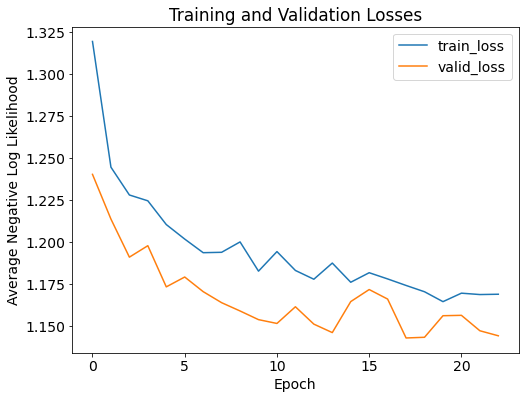

In [8]:
nnc.plot_history()

## predict

### Draw a random prediction

In [9]:
# Define the threshold
threshold = 0.4

# Draw a random image
img_selected = nnc.random_test_image()

# Run prediction (Bad coding; stolen directly from class)
img, ps, classes, y_obs = nnc.predict(img_selected, topk=5)


# Check if we can predict
if ps[0] > threshold:
    print(f"We predict {classes[0]} with {ps[0]*100} confidence%")
    print(f"true class was {y_obs}")    
    # Do stuff, such as moving to correct folder
else:
    print(f"Couldn't confidently predict a single label, guiding user with this:")
    nnc.display_prediction(img_selected, topk=5)
    # Maybe make a form for user to move to folder?

We predict angry with 63.28921318054199 confidence%
true class was angry


## Predict on all photos

In [10]:
# Define the threshold
threshold = 0.5

categories = nnc.get_categories()

preds = []
true = []

top1_true = 0
top2_true = 0
top3_true = 0
top4_true = 0
top5_true = 0

count = 0
#c = np.random.choice(self.categories)
for c in categories:
    root = testdir +"/"+ c + '/'
    imgs = os.listdir(root)
    for img in imgs:
        count = count +1 
        img_path = root + img
        
        img, ps, classes, y_obs = nnc.predict(img_path, topk=5)
        # Check if we can predict
        if ps[0] > threshold:
            print(f"We predict {classes[0]} with {ps[0]*100} confidence%. true class was {y_obs}")
            # Do stuff, such as moving to correct folder
            preds.append(classes[0])
            true.append(y_obs)
        else:
            print("did not accuractely predict")
            #print(f"Couldn't confidently predict a single label, guiding user with this:")
            #nnc.display_prediction(img_selected, topk=5)
            # Maybe make a form for user to move to folder?
        if classes[0] == y_obs:
            top1_true = top1_true +1
            top2_true = top2_true +1
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[1] == y_obs:
            top2_true = top2_true +1
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[2] == y_obs:
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[3] == y_obs:
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[4] == y_obs:
            top5_true = top5_true +1

did not accuractely predict
We predict happy with 72.36965298652649 confidence%. true class was happy
did not accuractely predict
We predict happy with 81.51349425315857 confidence%. true class was happy
We predict happy with 52.612221240997314 confidence%. true class was happy
We predict happy with 75.17167925834656 confidence%. true class was happy
We predict happy with 66.53620600700378 confidence%. true class was happy
We predict happy with 51.40174627304077 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 59.58794355392456 confidence%. true class was happy
We predict happy with 65.24435877799988 confidence%. true class was happy
did not accuractely predict
We predict happy with 58.176082372665405 confidence%. true class was happy
We predict neutral with 50.68435072898865 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did 

We predict happy with 58.71959924697876 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 86.31482124328613 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict angry with 51.856374740600586 confidence%. true class was happy
We predict happy with 68.83785128593445 confidence%. true class was happy
We predict angry with 52.28552222251892 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 52.72759795188904 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 89.8464560508728 confidence%.

We predict angry with 64.89380598068237 confidence%. true class was happy
We predict neutral with 50.79084634780884 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 56.14267587661743 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict fear with 52.13085412979126 confidence%. true class was happy
did not accuractely predict
We predict neutral with 53.92852425575256 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 55.00589609146118 confidence%. true class was happy
We predict happy with 79.81335520744324 confidence%. true class was happy
did not accuractely predict
We predict neutral with 51.828259229660034 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predi

did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 65.07601737976074 confidence%. true class was happy
We predict fear with 74.79137778282166 confidence%. true class was happy
did not accuractely predict
We predict neutral with 51.64608955383301 confidence%. true class was happy
We predict happy with 69.35575008392334 confidence%. true class was happy
did not accuractely predict
We predict happy with 86.35971546173096 confidence%. true class was happy
We predict happy with 58.74016284942627 confidence%. true class was happy
did not accuractely predict
We predict happy with 58.94075632095337 confidence%. true class was happy
did not accuractely predict
We predict happy with 58.53931903839111 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 87.29669451713562 confidence%. true class was happy
We predict happy with 51.

did not accuractely predict
We predict happy with 58.92735719680786 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 88.3159875869751 confidence%. true class was happy
We predict happy with 63.14024329185486 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 58.50852131843567 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 54.19292449951172 confidence%. true class was happy
We predict happy with 65.90608954429626 confidence%. true class was happy
We predict angry with 72.72642254829407 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not

We predict happy with 57.62125849723816 confidence%. true class was happy
did not accuractely predict
We predict happy with 51.41892433166504 confidence%. true class was happy
We predict happy with 86.88629865646362 confidence%. true class was happy
We predict neutral with 54.34946417808533 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 60.11316180229187 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict angry with 59.39355492591858 confidence%. true class was happy
We predict happy with 51.58933997154236 confidence%. true class was happy
We predict fear with 51.98719501495361 confidence%. true class was happy
did not accuractely predict
We predict neutral with 52.99367308616638 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 54.929882287979126 confidence%. true class was happy
We predict happy with 50.4175603

did not accuractely predict
did not accuractely predict
We predict happy with 52.85564661026001 confidence%. true class was happy
did not accuractely predict
We predict angry with 61.82932257652283 confidence%. true class was happy
We predict happy with 76.10493898391724 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 58.75507593154907 confidence%. true class was happy
did not accuractely predict
We predict neutral with 55.92220425605774 confidence%. true class was happy
We predict happy with 57.92831778526306 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 77.30591893196106 confidence%. true class was happy
did not accuractely predict
We predict happy with 60.76938509941101 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 55.84626793861389 co

did not accuractely predict
We predict neutral with 50.98205208778381 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 56.43424391746521 confidence%. true class was happy
did not accuractely predict
We predict happy with 55.05107641220093 confidence%. true class was happy
We predict happy with 60.704994201660156 confidence%. true class was happy
We predict neutral with 51.30508542060852 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 52.035391330718994 confidence%. true class was happy
We predict happy with 64.87186551094055 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 52.79114246368408 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 51.38832926750183 confidence%. true class 

did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 51.4964759349823 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 61.91795468330383 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 75.56965947151184 confidence%. true class was happy
did not accuractely predict
We predict happy with 83.54812860488892 confidence%. true class was happy
We predict neutral with 70.12609243392944 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 61.90754175186157 confidence%. true class was happy
We predict happy with 63.81217837333679 confidence%. true class was happy
did not accuractely predict
We predict happy with 80.08325099945068 confidence%. true class was happy
did not accuract

did not accuractely predict
did not accuractely predict
We predict happy with 51.74546241760254 confidence%. true class was happy
We predict happy with 54.557085037231445 confidence%. true class was happy
We predict happy with 74.17999505996704 confidence%. true class was happy
We predict happy with 57.066863775253296 confidence%. true class was happy
did not accuractely predict
We predict happy with 92.25114583969116 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 64.6318793296814 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 55.3702712059021 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 78.63256931304932 confidence%. true class was happy
did not accuractely predict
did not accuract

did not accuractely predict
did not accuractely predict
We predict happy with 79.83624935150146 confidence%. true class was happy
We predict happy with 53.382498025894165 confidence%. true class was happy
We predict neutral with 55.169326066970825 confidence%. true class was happy
We predict angry with 50.76581835746765 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 69.9550211429596 confidence%. true class was happy
did not accuractely predict
We predict neutral with 50.70366859436035 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 59.44557785987854 confidence%. true class was happy
We predict neutral with 61.94986701011658 confidence%. true class was happy
We predict happy with 59.67572331428528 confidence%. true class w

did not accuractely predict
We predict neutral with 55.84011673927307 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 71.43934965133667 confidence%. true class was sad
did not accuractely predict
We predict happy with 50.42414665222168 confidence%. true class was sad
We predict happy with 59.71967577934265 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 54.377394914627075 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 51.931893825531006 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict


We predict neutral with 50.86694359779358 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 65.801340341568 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 50.760418176651 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 50.117331743240356 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 65.801340341568 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with

We predict neutral with 55.30380606651306 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 59.46650505065918 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 85.75621843338013 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 55.69259524345398 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
We predict neutral with 55.601173639297485 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accurac

We predict neutral with 67.17166900634766 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 55.32498359680176 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 54.3140172958374 confidence%. true class was sad
did not accuractely predict
We predict neutral with 51.47460103034973 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 56.6314160823822 confidence%. true class was sad
did not accuractely predict
did not accuractely predict
We predict neutral with 75.72834491729736 co

did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 56.89624547958374 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 51.210129261016846 confidence%. true class was fear
did not accuractely predict
We predict fear with 62.54666447639465 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 61.46536469459534 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 51.75876021385193 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 75.99393725395203 confidence%. true class was fear
We predict happy with 70.165354013443 confidence%. true class was fear
We predict fear w

did not accuractely predict
We predict fear with 52.49037742614746 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 57.09048509597778 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 50.14939904212952 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict angry with 52.87548899650574 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
We predict angry with 63.79755735397339 confidence%. true class was fear
We predict fear with 50.85242986679077 confidence%. true class was fear
We predict fear with 57.58668780326843 confidence%. true class

did not accuractely predict
did not accuractely predict
We predict neutral with 68.41415166854858 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 54.504114389419556 confidence%. true class was angry
did not accuractely predict
We predict neutral with 56.68082237243652 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 62.9172682762146 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
We predict angry with 63.28921318054199 confidence%. true class was angry
We predict angry with 51.510632038116455 confidence%. true class was angry
We predict neutral with 51.96385979652405 confidence%. true class was angry
did not accuractely predict
We predict happy with 69.10725831985474 confidence%. true class was angry
We predi

did not accuractely predict
did not accuractely predict
We predict neutral with 66.53478145599365 confidence%. true class was angry
We predict angry with 63.14147710800171 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 50.076478719711304 confidence%. true class was angry
We predict neutral with 50.97460746765137 confidence%. true class was angry
did not accuractely predict
We predict happy with 67.84827709197998 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
We predict happy with 60.97331643104553 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 62.727826833724976 confidence%. true class was angry
did not accuractely predict
We predict angry with 55.59344291687012 confidence%. true class was angry
did not 

did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 86.78466081619263 confidence%. true class was angry
We predict neutral with 50.50071477890015 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
We predict neutral with 71.02894186973572 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 52.359598875045776 confidence%. true class was angry
We predict happy with 70.4721450805664 confidence%. true class was angry
We predict neutral with 56.912046670913696 confidence%. true class was angry
We predict happy with 52.65517830848694 confidence%. true class was angry
did not accuractely predict
did not accuractely predict
We predict neutral with 51.813727617263794 confidence%. true class was angry
We predict angry with 80.63856

did not accuractely predict
We predict fear with 58.13018083572388 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict angry with 68.22872757911682 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 58.972883224487305 confidence%. true class was neutral
We predict fear with 56.53545260429382 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 52.233290672302246 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 66.21983051300049 confidence%. true class was neutral
did not accuractely predict
We predict happy with 62.7855122089386 confidence%. true class was neutral
We predict neutral with 51.44703984260559 confidence%. true class was neutr

We predict neutral with 72.48685956001282 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 80.44862747192383 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 72.53888845443726 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 51.08702778816223 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 50.16747713088989 confidence%. true class was neutral
We predict neutral with 50.20865797996521 confidence%. true class was neutral
We predict neutral with 80.37989139556885 confidence%. true class was neutral
We predict neutral with 58.39747190475464 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 80.63435554504395 confidence%. true class was neutral
did not accuractely predict
did not accuractely pre

did not accuractely predict
We predict neutral with 58.99297595024109 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 74.2605984210968 confidence%. true class was neutral
We predict neutral with 55.0947368144989 confidence%. true class was neutral
did not accuractely predict
We predict happy with 52.09288001060486 confidence%. true class was neutral
We predict neutral with 60.101425647735596 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 54.49777841567993 confidence%. true class was neutral
We predict happy with 69.88413333892822 confidence%. true class was neutral
We predict neutral with 93.23408603668213 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 50.40763020515442 confidence%. true class was neu

did not accuractely predict
We predict neutral with 62.906330823898315 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict happy with 50.92483162879944 confidence%. true class was neutral
We predict neutral with 52.60460376739502 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 58.85545611381531 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 50.92829465866089 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predi

did not accuractely predict
We predict neutral with 52.85214185714722 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 53.81980538368225 confidence%. true class was neutral
We predict neutral with 66.49765372276306 confidence%. true class was neutral
did not accuractely predict
We predict angry with 51.2311577796936 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 68.49873661994934 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict happy with 57.10412859916687 confidence%. true class was neutral
We predict neutral with 60.113394260406494 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 55.78206777572632 confidence%. true class was neutral
did not accuract

did not accuractely predict
We predict neutral with 51.16294026374817 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 50.722914934158325 confidence%. true class was neutral
We predict neutral with 75.19730925559998 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 63.452839851379395 confidence%. true class was neutral
did not accuractely predict
We predict happy with 53.49217653274536 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict happy with 51.74809694290161 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 64.65381979942322 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 65.93818068504333 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neu

did not accuractely predict
did not accuractely predict
We predict neutral with 86.55884861946106 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 64.82207775115967 confidence%. true class was neutral
We predict neutral with 78.33443880081177 confidence%. true class was neutral
We predict neutral with 61.122798919677734 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 75.10622143745422 confidence%. true class was neutral
We predict neutral with 51.4306366443634 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 65.46670794487 confidence%. true class was neutral
We predict happy with 50.2363920211792 confidence%. true class was neutral
We predict neutral with 60.129714012145996 confidence%. true class was neu

did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 51.79826617240906 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 59.385210275650024 confidence%. true class was neutral
We predict fear with 55.91102838516235 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 84.83997583389282 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 66.97595119476318 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 63.142597675323486 confidence%. true class was neutral
We predict fear with 51.683259010

We predict neutral with 55.3616464138031 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 53.406840562820435 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 65.84548950195312 confidence%. true class was neutral
We predict neutral with 54.75568175315857 confidence%. true class was neutral
did not accuractely predict
We predict fear with 61.665791273117065 confidence%. true class was neutral
We predict neutral with 51.21060013771057 confidence%. true class was neutral
We predict happy with 54.72179055213928 confidence%. true class was neutral
did not accuractely predict
We predict

did not accuractely predict
We predict neutral with 80.7746410369873 confidence%. true class was neutral
We predict neutral with 56.96007013320923 confidence%. true class was neutral
We predict neutral with 54.1203498840332 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 52.94790863990784 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 51.72221660614014 confidence%. true class was neutral
did not accuractely predict
did not accuractely predic

did not accuractely predict
We predict neutral with 52.42184400558472 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 73.75165224075317 confidence%. true class was neutral
We predict fear with 50.13933181762695 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 69.88040804862976 confidence%. true class was neutral
We predict neutral with 61.976540088653564 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 62.616950273513794 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We p

did not accuractely predict
did not accuractely predict
We predict neutral with 67.97679662704468 confidence%. true class was neutral
We predict neutral with 59.6413791179657 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 54.03560996055603 confidence%. true class was neutral
We predict neutral with 50.217556953430176 confidence%. true class was neutral
did not accuractely predict
We predict fear with 71.09081149101257 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 60.81675887107849 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 53.2382607460022 confidence%. true class was neutral
We predict neutral with 50.95325708389282 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 52.04026699066162 confidence%. true class was ne

We predict neutral with 53.10479998588562 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 79.71831560134888 confidence%. true class was neutral
We predict neutral with 55.338889360427856 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 52.706509828567505 confidence%. true class was neutral
did not accuractely predict
We predict happy with 63.26359510421753 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 60.410475730895996 confidence%. true class was neutral
We predict neutral with 77.86186337471008 confidence%. 

did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 53.88490557670593 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 81.0016393661499 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 54.17836308479309 confidence%. true class was neutral
We predict happy with 86.2369954586029 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 64.22969102859497 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 77.77433395385742 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 82.47676491737366 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 73.69996905326

We predict neutral with 60.768574476242065 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 61.11411452293396 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
We predict neutral with 55.3122341632843 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 69.16647553443909 confidence%. true class was neutral
We predict neutral with 56.27679228782654 confidence%. true class was neutral
We predict neutral with 69.43792700767517 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 55.138570070266724 confidence%. true class was neutral
did not accuractely predict
We pred

did not accuractely predict
We predict neutral with 57.14622735977173 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 50.14439821243286 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict neutral with 61.767029762268066 confidence%. true class was neutral
We predict fear with 52.17640399932861 confidence%. true class was neutral
We predict happy with 52.962952852249146 confidence%. true class was neutral
did not accuractely predict
We predict neutral with 63.29248547554016 confidence%. true class was neutral
We predict happy with 52.753746509552 confidence%. true class was neutral
We predict neutral with 56.10896348953247 confidence%. true class was neutral
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy wi

In [11]:
a = preds
b = true

acc = sum(1 for x,y in zip(a,b) if x == y) / len(a)

print(f"Predicted on {len(a)} images ({100*len(a) / count})% of the dataset. got an accuracy of {100*acc}%")

Predicted on 2479 images (34.71016521982638)% of the dataset. got an accuracy of 66.07503025413473%


In [12]:
print(f" our top 1 guess was correct {top1_true} times - meaning a accuracy of {100 * top1_true/count} %")
print(f" our top 2 guess was correct {top2_true} times - meaning a accuracy of {100 * top2_true/count} %")
print(f" our top 3 guess was correct {top3_true} times - meaning a accuracy of {100 * top3_true/count} %")
print(f" our top 4 guess was correct {top4_true} times - meaning a accuracy of {100 * top4_true/count} %")
print(f" our top 5 guess was correct {top5_true} times - meaning a accuracy of {100 * top5_true/count} %")

 our top 1 guess was correct 3701 times - meaning a accuracy of 51.82021842621115 %
 our top 2 guess was correct 5411 times - meaning a accuracy of 75.76309157098852 %
 our top 3 guess was correct 6310 times - meaning a accuracy of 88.35060207224868 %
 our top 4 guess was correct 6919 times - meaning a accuracy of 96.8776253150378 %
 our top 5 guess was correct 7142 times - meaning a accuracy of 100.0 %


## Try out different Thresholds
Same as above, but trying out various thresholds - and no longer printing

Just realized - two minutes of thinking could have saved us. absolutely NO NEED to rerun all predictions 9 times - Could have stored the results... But too late now!

Do we want to show Confusion matrix as well?

In [13]:
thresholds = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75]
for threshold in thresholds:

    categories = nnc.get_categories()

    preds = []
    true = []

    top1_true = 0
    top2_true = 0
    top3_true = 0
    top4_true = 0
    top5_true = 0

    count = 0
    #c = np.random.choice(self.categories)
    for c in categories:
        root = testdir +"/"+ c + '/'
        imgs = os.listdir(root)
        for img in imgs:
            count = count +1 
            img_path = root + img

            img, ps, classes, y_obs = nnc.predict(img_path, topk=5)
            # Check if we can predict
            if ps[0] > threshold:
                #print(f"We predict {classes[0]} with {ps[0]*100} confidence%. true class was {y_obs}")
                # Do stuff, such as moving to correct folder
                preds.append(classes[0])
                true.append(y_obs)
            #else:
                #print("did not accuractely predict")
                #print(f"Couldn't confidently predict a single label, guiding user with this:")
                #nnc.display_prediction(img_selected, topk=5)
                # Maybe make a form for user to move to folder?
            if classes[0] == y_obs:
                top1_true = top1_true +1
                top2_true = top2_true +1
                top3_true = top3_true +1
                top4_true = top4_true +1
                top5_true = top5_true +1
            if classes[1] == y_obs:
                top2_true = top2_true +1
                top3_true = top3_true +1
                top4_true = top4_true +1
                top5_true = top5_true +1
            if classes[2] == y_obs:
                top3_true = top3_true +1
                top4_true = top4_true +1
                top5_true = top5_true +1
            if classes[3] == y_obs:
                top4_true = top4_true +1
                top5_true = top5_true +1
            if classes[4] == y_obs:
                top5_true = top5_true +1
    a = preds
    b = true

    acc = sum(1 for x,y in zip(a,b) if x == y) / len(a)
    
    print("-----------------------------------------------------------------------------------------")
    print(f"Threshold was set to: {threshold}")
    print("-------------")
    print(f"Predicted on {len(a)} images ({100*len(a) / count})% of the dataset. got an accuracy of {100*acc}%")

-----------------------------------------------------------------------------------------
Threshold was set to: 0.35
-------------
Predicted on 5866 images (82.13385606272753)% of the dataset. got an accuracy of 55.45516535969996%
-----------------------------------------------------------------------------------------
Threshold was set to: 0.4
-------------
Predicted on 4645 images (65.03780453654439)% of the dataset. got an accuracy of 58.32077502691065%
-----------------------------------------------------------------------------------------
Threshold was set to: 0.45
-------------
Predicted on 3493 images (48.90786894427331)% of the dataset. got an accuracy of 61.60893215001432%
-----------------------------------------------------------------------------------------
Threshold was set to: 0.5
-------------
Predicted on 2479 images (34.71016521982638)% of the dataset. got an accuracy of 66.07503025413473%
------------------------------------------------------------------------------

### Predict from imagepath
This is a starting point for the actual task... Currently drawing a random sample of 10

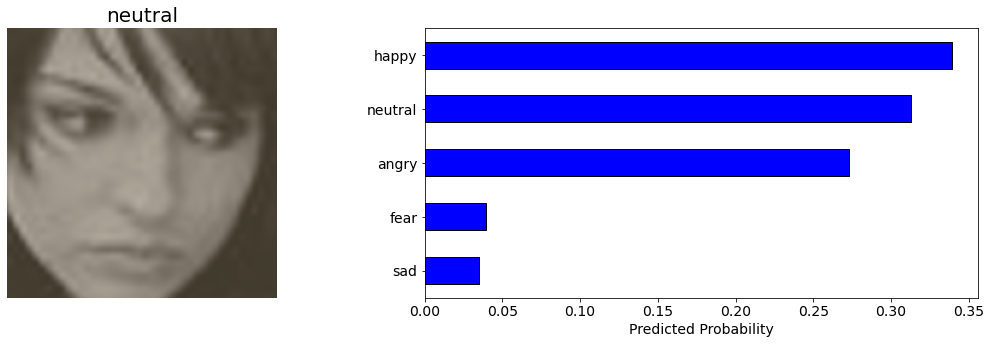

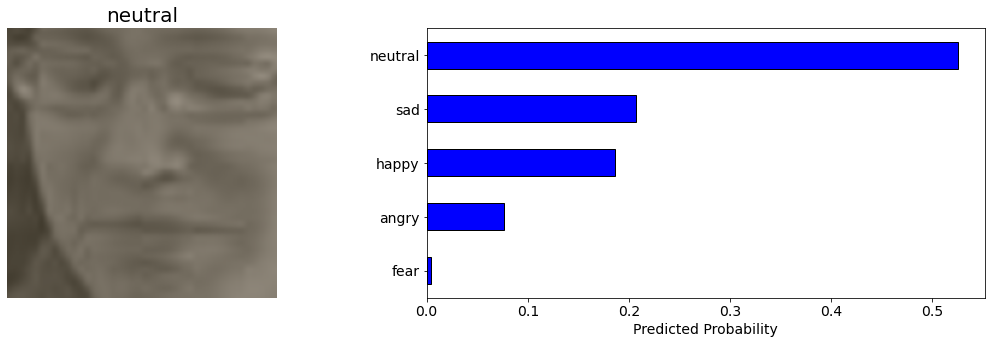

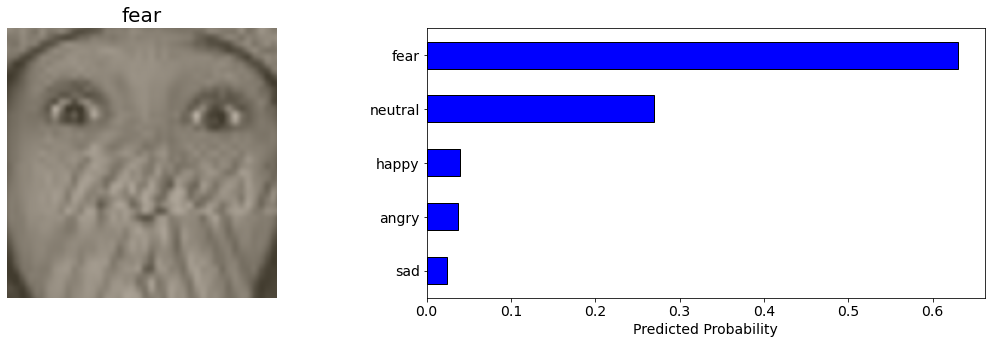

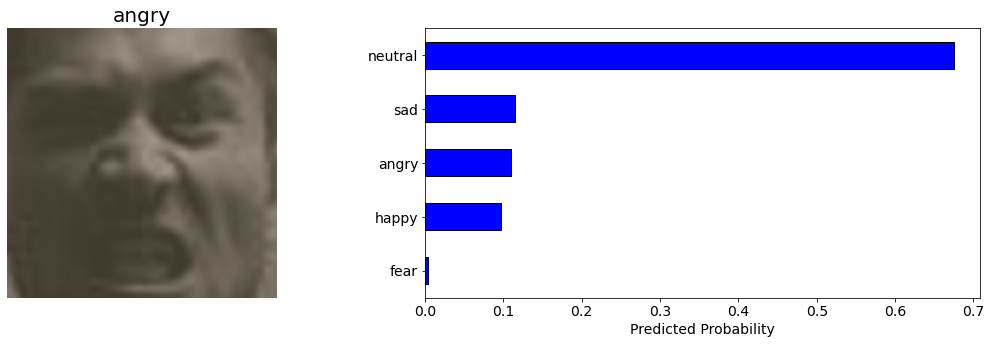

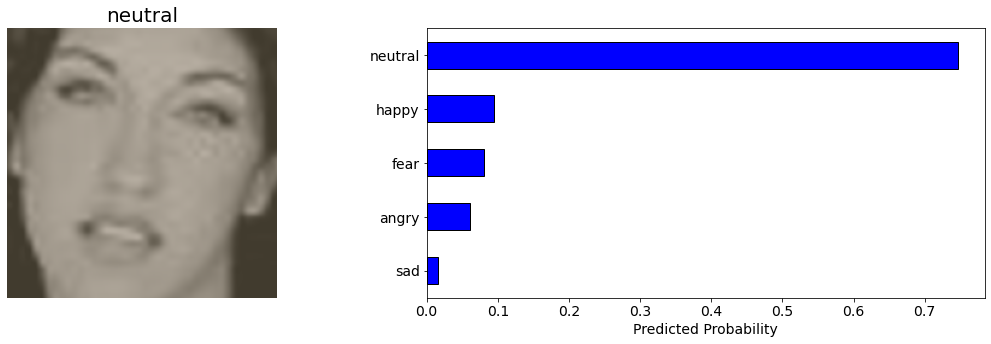

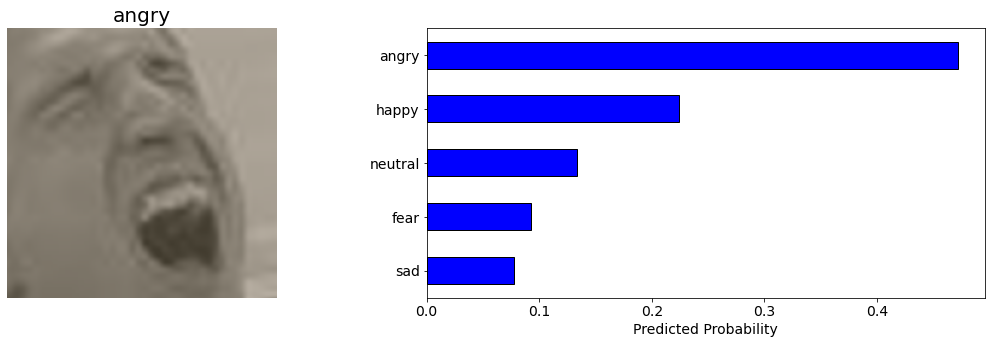

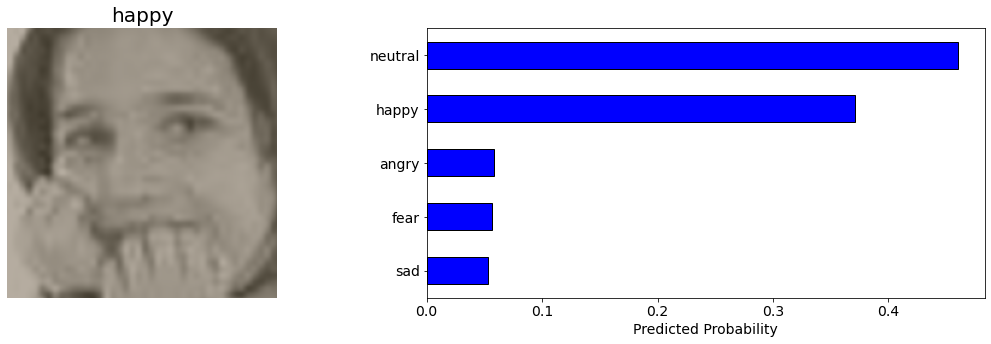

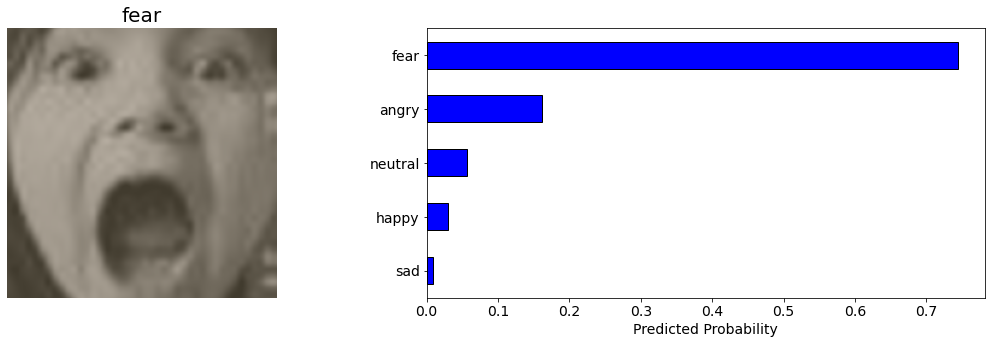

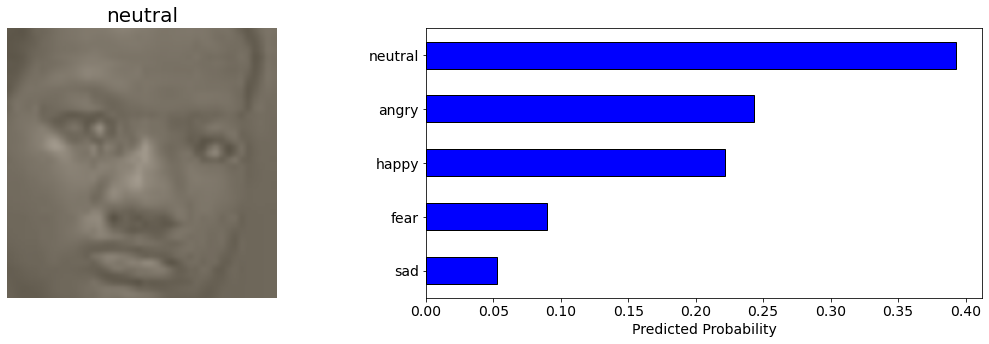

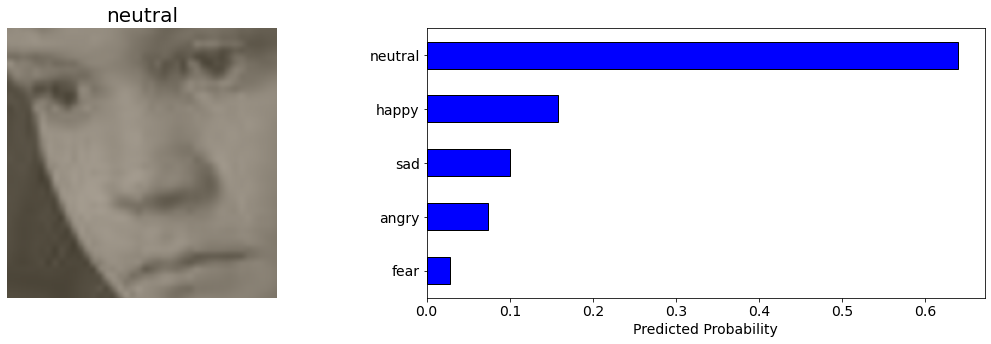

In [14]:
for i in range(10):
    root = testdir +"/"+ np.random.choice(nnc.get_categories()) + '/'
    img_path = root + np.random.choice(os.listdir(root))
    nnc.display_prediction(img_path, topk=5)